In [1]:
import tifffile as tf
import numpy as np
import pandas as pd
import numpy.polynomial.polynomial as P
import scipy.spatial as spatial
import scipy.ndimage as ndimage
from importlib import reload

import arabidopsis_utils as thales
import MinimumBoundingBox as mbb

# Get 4 pots

In [2]:
tiff_file = '../raw3d/col-0.tif'
pot_dst = '../pots/'

src, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]

dst = pot_dst + bname + '/'

In [3]:
filename = dst + 'soilless.tif'
img = tf.imread(filename)

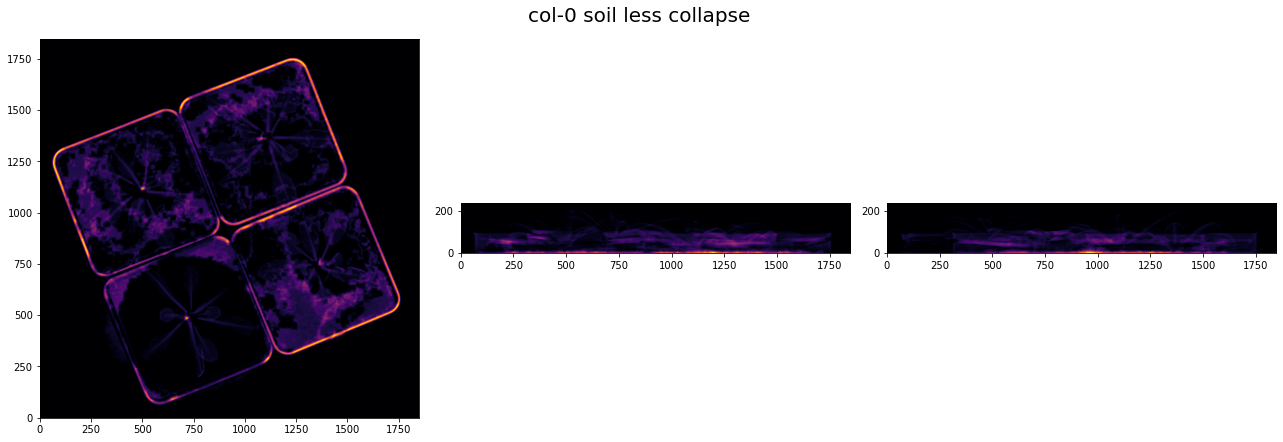

In [5]:
snaps = thales.collapse_dimensions(img)
thales.plot_collapse_dimensions(snaps, bname, 'soil less')

In [18]:
pts = snaps[0].copy()
pts = (255*pts/np.max(pts)).astype(np.uint8).reshape(snaps[0].shape)
pts[pts < 50] = 0
pts[pts > 0] = 1
border = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])

surface = ndimage.convolve(pts, border, np.int8, 'constant', cval=0)
surface[ surface < 0 ] = 0
surface = surface.astype(np.uint8)
surface[ surface > 0 ] = 1

In [19]:
corners = thales.four_corners(surface)
tpt, rpt, bpt, lpt = corners
center = np.mean(corners,axis=0)
print(tpt, rpt, bpt, lpt, sep='\n')

rhull = np.vstack((lpt,tpt,rpt,bpt,lpt))

[1786.74885151 1276.9157978 ]
[ 529.69279283 1782.9511441 ]
[ 27.14597918 534.56104352]
[1284.20203786   28.52569722]


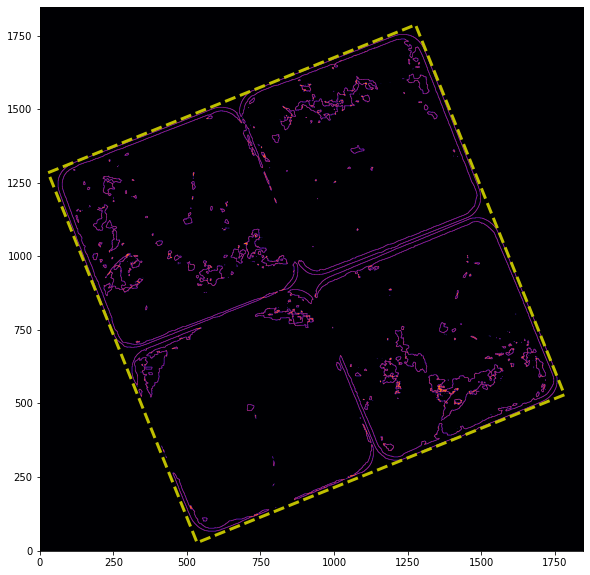

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(surface, cmap='inferno', origin='lower');
#plt.plot(rect[hull.vertices,1], rect[hull.vertices,0], 'y--', lw=2);
plt.plot(rhull[:,1], rhull[:,0], 'y--', lw=3);

In [25]:
pts = snaps[0].copy()
pts = (255*pts/np.max(pts)).astype(np.uint8).reshape(snaps[0].shape)
pts[pts > 0] = 1
surface = ndimage.convolve(pts, border, np.int8, 'constant', cval=0)
surface[ surface < 0 ] = 0
surface = surface.astype(np.uint8)
surface[ surface > 0 ] = 1

In [23]:
bcoefs = thales.four_borderlines(corners)
midpoints = thales.four_midpoints(corners)
mcoefs = thales.midline_splits(midpoints)
centers = thales.four_centers(corners, midpoints)

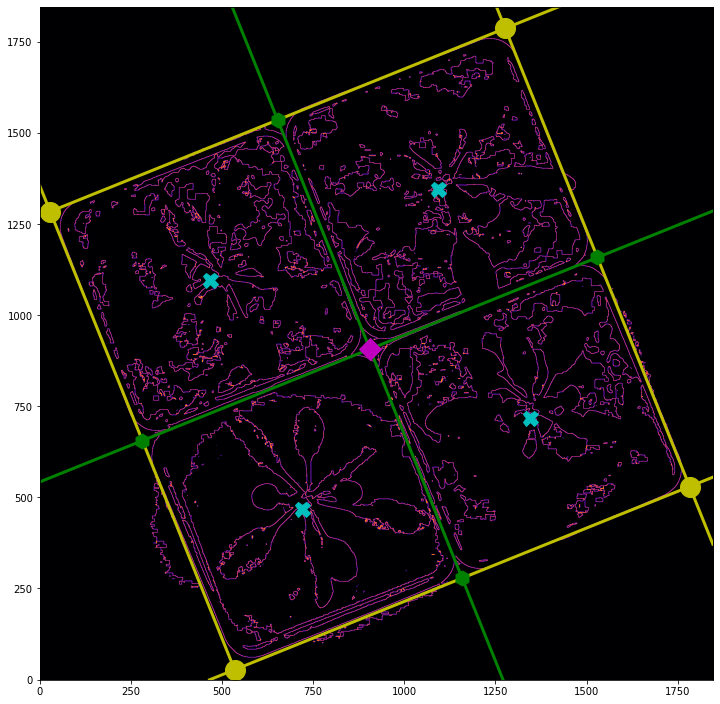

In [41]:
plt.figure(figsize=(10,10))
plt.imshow(surface, cmap='inferno', origin='lower');
for i in range(len(bcoefs)):
    plt.axline(corners[i,:][::-1], slope=bcoefs[i,1], c='y', lw=3)
    plt.plot(corners[i,1], corners[i,0], 'yo', ms=20)
    plt.plot(centers[i,1], centers[i,0], 'cX', ms=15)
    plt.plot(midpoints[i,1], midpoints[i,0], 'gh', ms=15)
for i in range(len(mcoefs)):
    plt.axline(midpoints[i,:][::-1], slope=mcoefs[i,1], c='g', lw=3)

plt.plot(center[1], center[0], 'mD', ms=15);
plt.tight_layout()

filename = dst + bname + '_split_pots.jpg'
plt.savefig(filename, dpi=96, pil_kwargs={'optimize':True})

In [33]:
foo = midpoints - center
bar = np.sqrt(np.sum(foo**2, axis=1)).reshape(foo.shape[0],1)
WS = foo/bar
bs = bcoefs[:,0]/(bcoefs[:,1]*WS[:,1] - WS[:,0])

In [34]:
foo = midpoints[np.array([2,1]), :] - corners[2,:]
bar = np.sqrt(np.sum(foo**2, axis=1)).reshape(foo.shape[0],1)
ZS = foo/bar
cs = mcoefs[:,0]/(mcoefs[:,1]*ZS[:,1] - ZS[:,0])

In [35]:
filename = dst + bname + '_2d_measurements.csv'

columns = ['cornerX', 'cornerY',
           'border_int', 'border_slope',
           'midpointX', 'midpointY',
           'centersX', 'centersY',
           'WX', 'WY', 'b']

index = ['tmost', 'rmost', 'bmost', 'lmost']

pd.DataFrame(np.column_stack((corners, bcoefs, midpoints, centers, WS, bs)), 
             columns=columns, index=index).to_csv(filename)

In [37]:
filename = dst + bname + '_2d_measurements_supp.csv'

columns = ['mid_int', 'mid_slope', 'ZX', 'ZY', 'c']

index = ['horz', 'vert']

pd.DataFrame(np.column_stack((mcoefs, ZS, cs)),
             columns=columns, index=index).to_csv(filename)

# Go to 3D

In [43]:
coords = thales.tiff2coords(img, False)
print(coords.shape) #84.9M

(20772580, 3)


In [44]:
W3D = np.column_stack((np.zeros(len(WS)), WS))
Z3D = np.column_stack((np.zeros(len(ZS)), ZS))

In [45]:
orientation = np.full((len(coords), len(W3D)), False, dtype=np.bool)

for i in range(len(W3D)):
    W = W3D[i, :]
    b = bs[i]

    orientation[:, i] = np.sum(coords*W, axis=1) + b < 0

In [46]:
coords = coords[np.sum(orientation, axis=1) == len(W3D),:]

In [47]:
orientation = np.full((len(coords), len(Z3D)), False, dtype=np.bool)

for i in range(len(Z3D)):
    W = Z3D[i, :]
    b = cs[i]

    orientation[:, i] = np.sum(coords*W, axis=1) + b < 0

In [50]:
potcoords = coords[np.sum(orientation, axis=1) == len(Z3D), :]
print(potcoords.shape)

new_mask = np.empty_like(img)
new_mask[potcoords[:,0], potcoords[:,1], potcoords[:,2]] = True

pot3 = new_mask*img
snaps3 = thales.collapse_dimensions(pot3)

(2538341, 3)


In [52]:
potcoords = coords[np.sum(orientation, axis=1) == 0, :]
print(potcoords.shape)

new_mask = np.empty_like(img)
new_mask[potcoords[:,0], potcoords[:,1], potcoords[:,2]] = True

pot0 = new_mask*img
snaps0 = thales.collapse_dimensions(pot0)

(5591997, 3)


In [53]:
orientation = np.full((len(coords), len(Z3D)), False, dtype=np.bool)

i=0
W = Z3D[i, :]
b = cs[i]
orientation[:, i] = np.sum(coords*W, axis=1) + b < 0

i=1
W = Z3D[i, :]
b = cs[i]
orientation[:, i] = np.sum(coords*W, axis=1) + b < 0

In [54]:
potcoords = coords[(np.sum(orientation, axis=1) == 1) & (orientation[:,1]), :]
print(potcoords.shape)

new_mask = np.empty_like(img)
new_mask[potcoords[:,0], potcoords[:,1], potcoords[:,2]] = True

pot2 = new_mask*img
snaps2 = thales.collapse_dimensions(pot2)

(5633812, 3)


In [55]:
potcoords = coords[(np.sum(orientation, axis=1) == 1) & (orientation[:,0]), :]
print(potcoords.shape)

new_mask = np.empty_like(img)
new_mask[potcoords[:,0], potcoords[:,1], potcoords[:,2]] = True

pot1 = new_mask*img
snaps1 = thales.collapse_dimensions(pot1)

(6871190, 3)


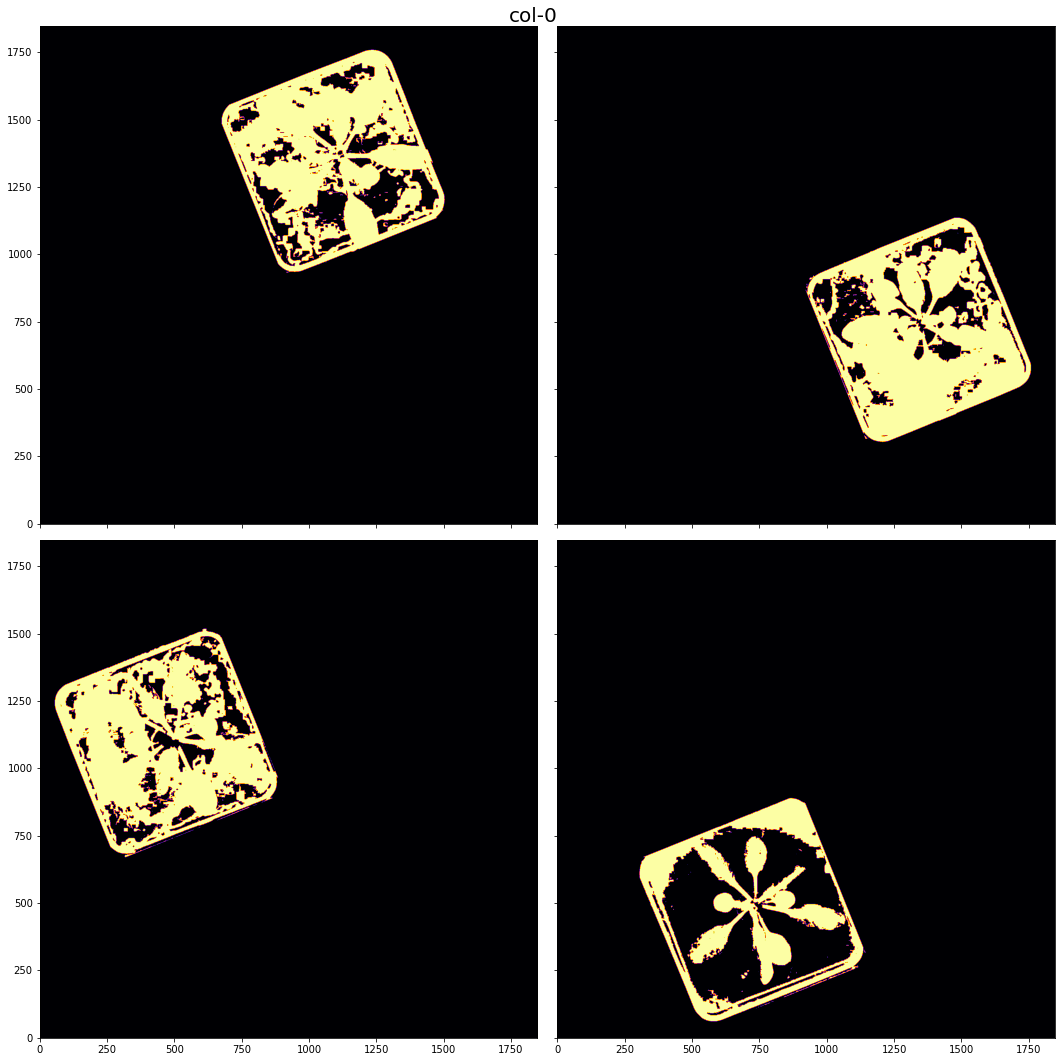

In [64]:
fig, ax = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey= True)

ax[0,0].imshow(snaps0[0] > 0, cmap='inferno', origin='lower');
ax[0,1].imshow(snaps1[0] > 0, cmap='inferno', origin='lower');
ax[1,0].imshow(snaps2[0] > 0, cmap='inferno', origin='lower');
ax[1,1].imshow(snaps3[0] > 0, cmap='inferno', origin='lower');

fig.suptitle(bname, fontsize = 20)

fig.tight_layout()
filename = dst + bname +'_separated_pots_4_binary.jpg'
plt.savefig(filename, dpi=96, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight')

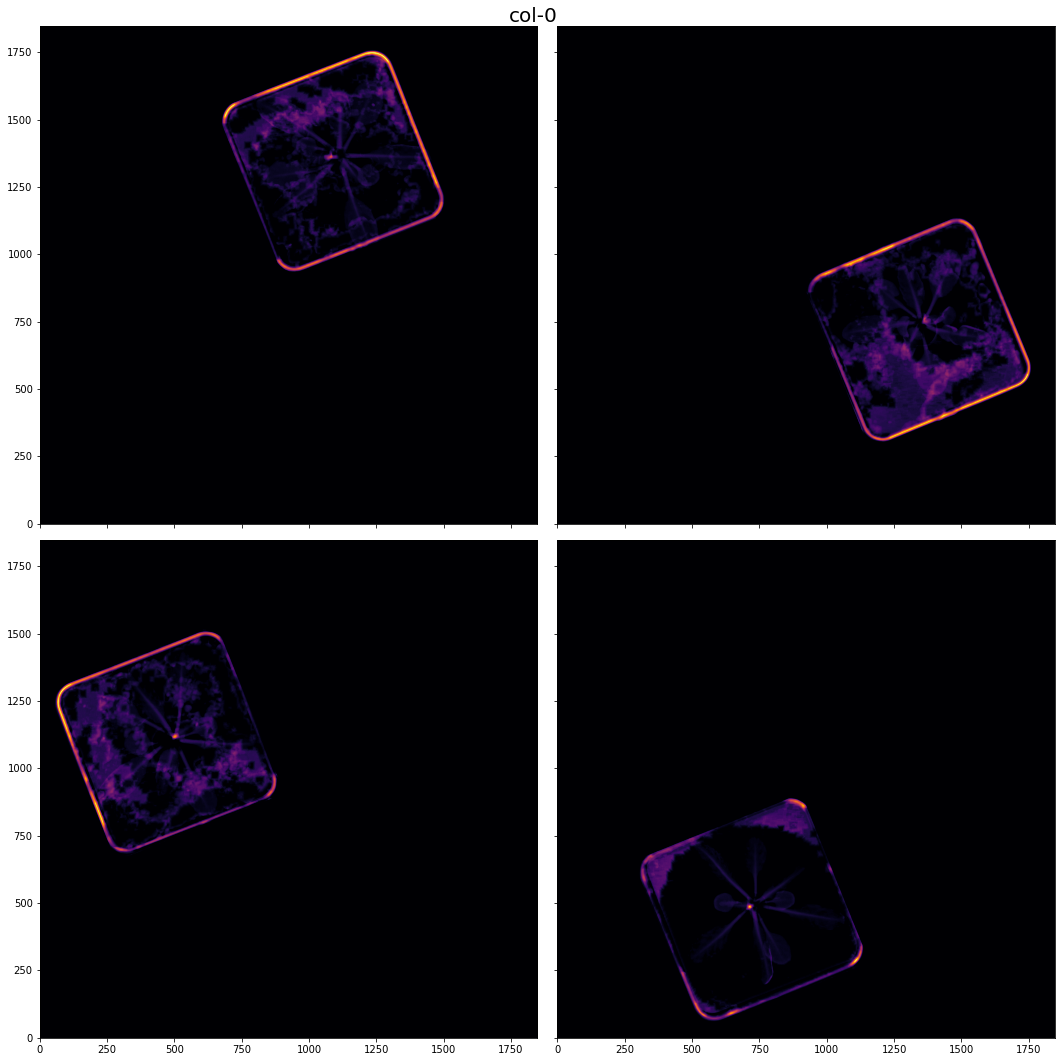

In [65]:
fig, ax = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey= True)

ax[0,0].imshow(snaps0[0], cmap='inferno', origin='lower');
ax[0,1].imshow(snaps1[0], cmap='inferno', origin='lower');
ax[1,0].imshow(snaps2[0], cmap='inferno', origin='lower');
ax[1,1].imshow(snaps3[0], cmap='inferno', origin='lower');

fig.suptitle(bname, fontsize = 20)

fig.tight_layout()
filename = dst + bname +'_separated_pots_4_color.jpg'
plt.savefig(filename, dpi=96, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight')

In [66]:
filename = dst + bname + '_pot'

tf.imwrite(filename + '0.tif', pot0 , photometric='minisblack',compress=3)
tf.imwrite(filename + '1.tif', pot1 , photometric='minisblack',compress=3)
tf.imwrite(filename + '2.tif', pot2 , photometric='minisblack',compress=3)
tf.imwrite(filename + '3.tif', pot3 , photometric='minisblack',compress=3)